**ENVIRONMENT SETUP & LIBRARIES**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import joblib
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.impute import SimpleImputer

In [2]:
try:
    from sklearn.preprocessing import TargetEncoder
    IS_SKLEARN_TARGET_ENCODER = True
except ImportError:
    try:
        from category_encoders import TargetEncoder
        IS_SKLEARN_TARGET_ENCODER = False
    except ImportError:
        raise ImportError("TargetEncoder missing. Run: !pip install category_encoders")

In [3]:
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11
print("✅ Environment Initialized")

✅ Environment Initialized


**DATA INGESTION**

In [4]:
DATA_PATH = '/kaggle/input/vehicle-price-prediction/vehicle_price_prediction.csv' 

df = pd.read_csv(DATA_PATH)
print(f"Data Loaded: {df.shape[0]:,} rows | {df.shape[1]} columns")
display(df.head(5))

Data Loaded: 1,000,000 rows | 20 columns


,make,model,year,mileage,engine_hp,transmission,fuel_type,drivetrain,body_type,exterior_color,interior_color,owner_count,accident_history,seller_type,condition,trim,vehicle_age,mileage_per_year,brand_popularity,price
0,Volkswagen,Jetta,2016,183903,173,Manual,Electric,RWD,Sedan,Blue,Brown,5,NaN,Dealer,Excellent,EX,9,20433.666667,0.040054,7208.52
1,Lexus,RX,2010,236643,352,Manual,Gasoline,FWD,Sedan,Silver,Beige,5,Minor,Dealer,Good,LX,15,15776.200000,0.039921,6911.81
2,Subaru,Crosstrek,2016,103199,188,Automatic,Diesel,AWD,Sedan,Silver,Beige,5,NaN,Dealer,Excellent,Touring,9,11466.555556,0.040230,11915.63
3,Cadillac,Lyriq,2016,118889,338,Manual,Gasoline,AWD,SUV,Black,Gray,3,NaN,Private,Good,Base,9,13209.888889,0.039847,25984.79
4,Toyota,Highlander,2018,204170,196,Manual,Diesel,FWD,Sedan,Red,Brown,5,Minor,Dealer,Excellent,Sport,7,29167.142857,0.039627,8151.30


**FEATURE ENGINEERING (PRODUCTION LOGIC)**

In [5]:
# 1. Temporal Features
if 'vehicle_age' not in df.columns and 'year' in df.columns:
    df['vehicle_age'] = 2025 - df['year']

# 2. Usage Intensity Metrics
if 'mileage_per_year' not in df.columns:
    # Handle zero division for new cars
    df['mileage_per_year'] = df['mileage'] / df['vehicle_age'].replace(0, 1)

# 3. Categorical Imputation
if 'accident_history' in df.columns:
    df['accident_history'] = df['accident_history'].fillna('None')

# 4. Type Casting
if 'owner_count' in df.columns:
    df['owner_count'] = pd.to_numeric(df['owner_count'], errors='coerce')

# 5. Schema Alignment
cols_to_drop = ['year'] 
df = df.drop(columns=[c for c in cols_to_drop if c in df.columns], errors='ignore')

display(df.head(5))

,make,model,mileage,engine_hp,transmission,fuel_type,drivetrain,body_type,exterior_color,interior_color,owner_count,accident_history,seller_type,condition,trim,vehicle_age,mileage_per_year,brand_popularity,price
0,Volkswagen,Jetta,183903,173,Manual,Electric,RWD,Sedan,Blue,Brown,5,None,Dealer,Excellent,EX,9,20433.666667,0.040054,7208.52
1,Lexus,RX,236643,352,Manual,Gasoline,FWD,Sedan,Silver,Beige,5,Minor,Dealer,Good,LX,15,15776.200000,0.039921,6911.81
2,Subaru,Crosstrek,103199,188,Automatic,Diesel,AWD,Sedan,Silver,Beige,5,None,Dealer,Excellent,Touring,9,11466.555556,0.040230,11915.63
3,Cadillac,Lyriq,118889,338,Manual,Gasoline,AWD,SUV,Black,Gray,3,None,Private,Good,Base,9,13209.888889,0.039847,25984.79
4,Toyota,Highlander,204170,196,Manual,Diesel,FWD,Sedan,Red,Brown,5,Minor,Dealer,Excellent,Sport,7,29167.142857,0.039627,8151.30


**FEATURE SCHEMA DEFINITION**

In [6]:
TARGET_COL = 'price'

# Feature Grouping Strategy
# High Cardinality -> Target Encoding
HIGH_CARD_COLS = ['make', 'model', 'trim', 'exterior_color', 'interior_color']

# Low Cardinality -> One-Hot Encoding
LOW_CARD_COLS = ['transmission', 'fuel_type', 'drivetrain', 'body_type', 'seller_type', 'accident_history']

# Ordinal -> Ordinal Encoding
ORDINAL_COLS = ['condition']

# Numeric -> Scaling
NUMERIC_COLS = ['mileage', 'engine_hp', 'owner_count', 'vehicle_age', 'mileage_per_year', 'brand_popularity']

# Validation
valid_high = [c for c in HIGH_CARD_COLS if c in df.columns]
valid_low = [c for c in LOW_CARD_COLS if c in df.columns]
valid_ord = [c for c in ORDINAL_COLS if c in df.columns]
valid_num = [c for c in NUMERIC_COLS if c in df.columns]

print(f"Features Selected: {len(valid_high)} High Card | {len(valid_low)} Low Card | {len(valid_ord)} Ordinal | {len(valid_num)} Numeric")

Features Selected: 5 High Card | 6 Low Card | 1 Ordinal | 6 Numeric


**EXPLORATORY DATA ANALYSIS (CORRELATION)**

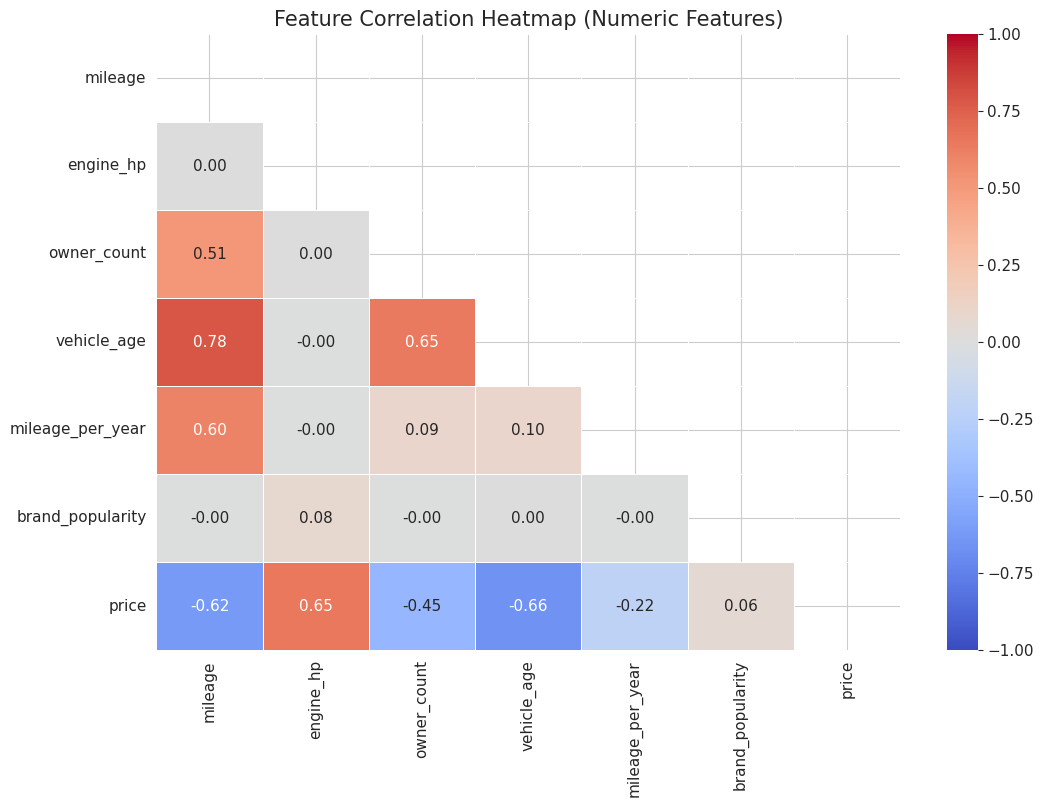

🔍 KEY INSIGHTS:
- Correlation between Mileage & Price: -0.62 (Negative correlation expected)
- Correlation between HP & Price:      0.65 (Positive correlation expected)
- Correlation between Age & Price:     -0.66 (Strong negative driver)


In [7]:
# 1. Select only numeric columns for correlation analysis
numeric_df = df.select_dtypes(include=[np.number])

# 2. Calculate Correlation Matrix
corr_matrix = numeric_df.corr()

# 3. Plot Heatmap
plt.figure(figsize=(12, 8))
# Create a mask to hide the upper triangle (redundant information)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool)) 

sns.heatmap(corr_matrix, 
            mask=mask,
            annot=True, 
            fmt=".2f", 
            cmap='coolwarm', 
            vmax=1, 
            vmin=-1, 
            linewidths=0.5)

plt.title('Feature Correlation Heatmap (Numeric Features)', fontsize=15)
plt.show()

# 4. Automated Insights
print("🔍 KEY INSIGHTS:")
if 'mileage' in corr_matrix.columns and 'price' in corr_matrix.columns:
    print(f"- Correlation between Mileage & Price: {corr_matrix.loc['mileage', 'price']:.2f} (Negative correlation expected)")
if 'engine_hp' in corr_matrix.columns and 'price' in corr_matrix.columns:
    print(f"- Correlation between HP & Price:      {corr_matrix.loc['engine_hp', 'price']:.2f} (Positive correlation expected)")
if 'vehicle_age' in corr_matrix.columns and 'price' in corr_matrix.columns:
    print(f"- Correlation between Age & Price:     {corr_matrix.loc['vehicle_age', 'price']:.2f} (Strong negative driver)")

**ADVANCED PIPELINE ARCHITECTURE**

In [8]:
# 1. Transformers
condition_order = [['Fair', 'Good', 'Excellent']]

ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(categories=condition_order, handle_unknown='use_encoded_value', unknown_value=-1))
])

onehot_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('encoder', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

target_encoder_impl = TargetEncoder(smooth='auto', target_type='continuous') if IS_SKLEARN_TARGET_ENCODER else TargetEncoder()
target_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('encoder', target_encoder_impl)
])

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

In [9]:
# 2. Processor
preprocessor = ColumnTransformer(
    transformers=[
        ('ord', ordinal_transformer, valid_ord),
        ('onehot', onehot_transformer, valid_low),
        ('target', target_transformer, valid_high),
        ('num', numeric_transformer, valid_num)
    ],
    remainder='drop'
)

In [10]:
# 3. Estimator (XGBoost)
# Configuration optimized for large-scale tabular data
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', xgb.XGBRegressor(
        n_estimators=2000,
        learning_rate=0.02,
        max_depth=9,
        subsample=0.85,
        colsample_bytree=0.85,
        tree_method='hist', # GPU/High-Performance Histogram training
        random_state=42,
        n_jobs=-1
    ))
])

**MODEL TRAINING**

In [11]:
X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

pipeline.fit(X_train, y_train)
print("✅ Training Pipeline Complete")

✅ Training Pipeline Complete


**PERFORMANCE METRICS**

In [12]:
y_pred = pipeline.predict(X_test)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = mean_absolute_percentage_error(y_test, y_pred)
accuracy = 100 * (1 - mape)

print("-" * 30)
print("MODEL PERFORMANCE SCORECARD")
print("-" * 30)
print(f"Accuracy: {accuracy:.2f}%")
print(f"R² Score: {r2:.4f}")
print(f"MAE:      ${mae:,.2f}")
print(f"RMSE:     ${rmse:,.2f}")
print("-" * 30)

------------------------------
MODEL PERFORMANCE SCORECARD
------------------------------
Accuracy: 95.72%
R² Score: 0.9917
MAE:      $829.68
RMSE:     $1,245.51
------------------------------


**ADVANCED DIAGNOSTICS**

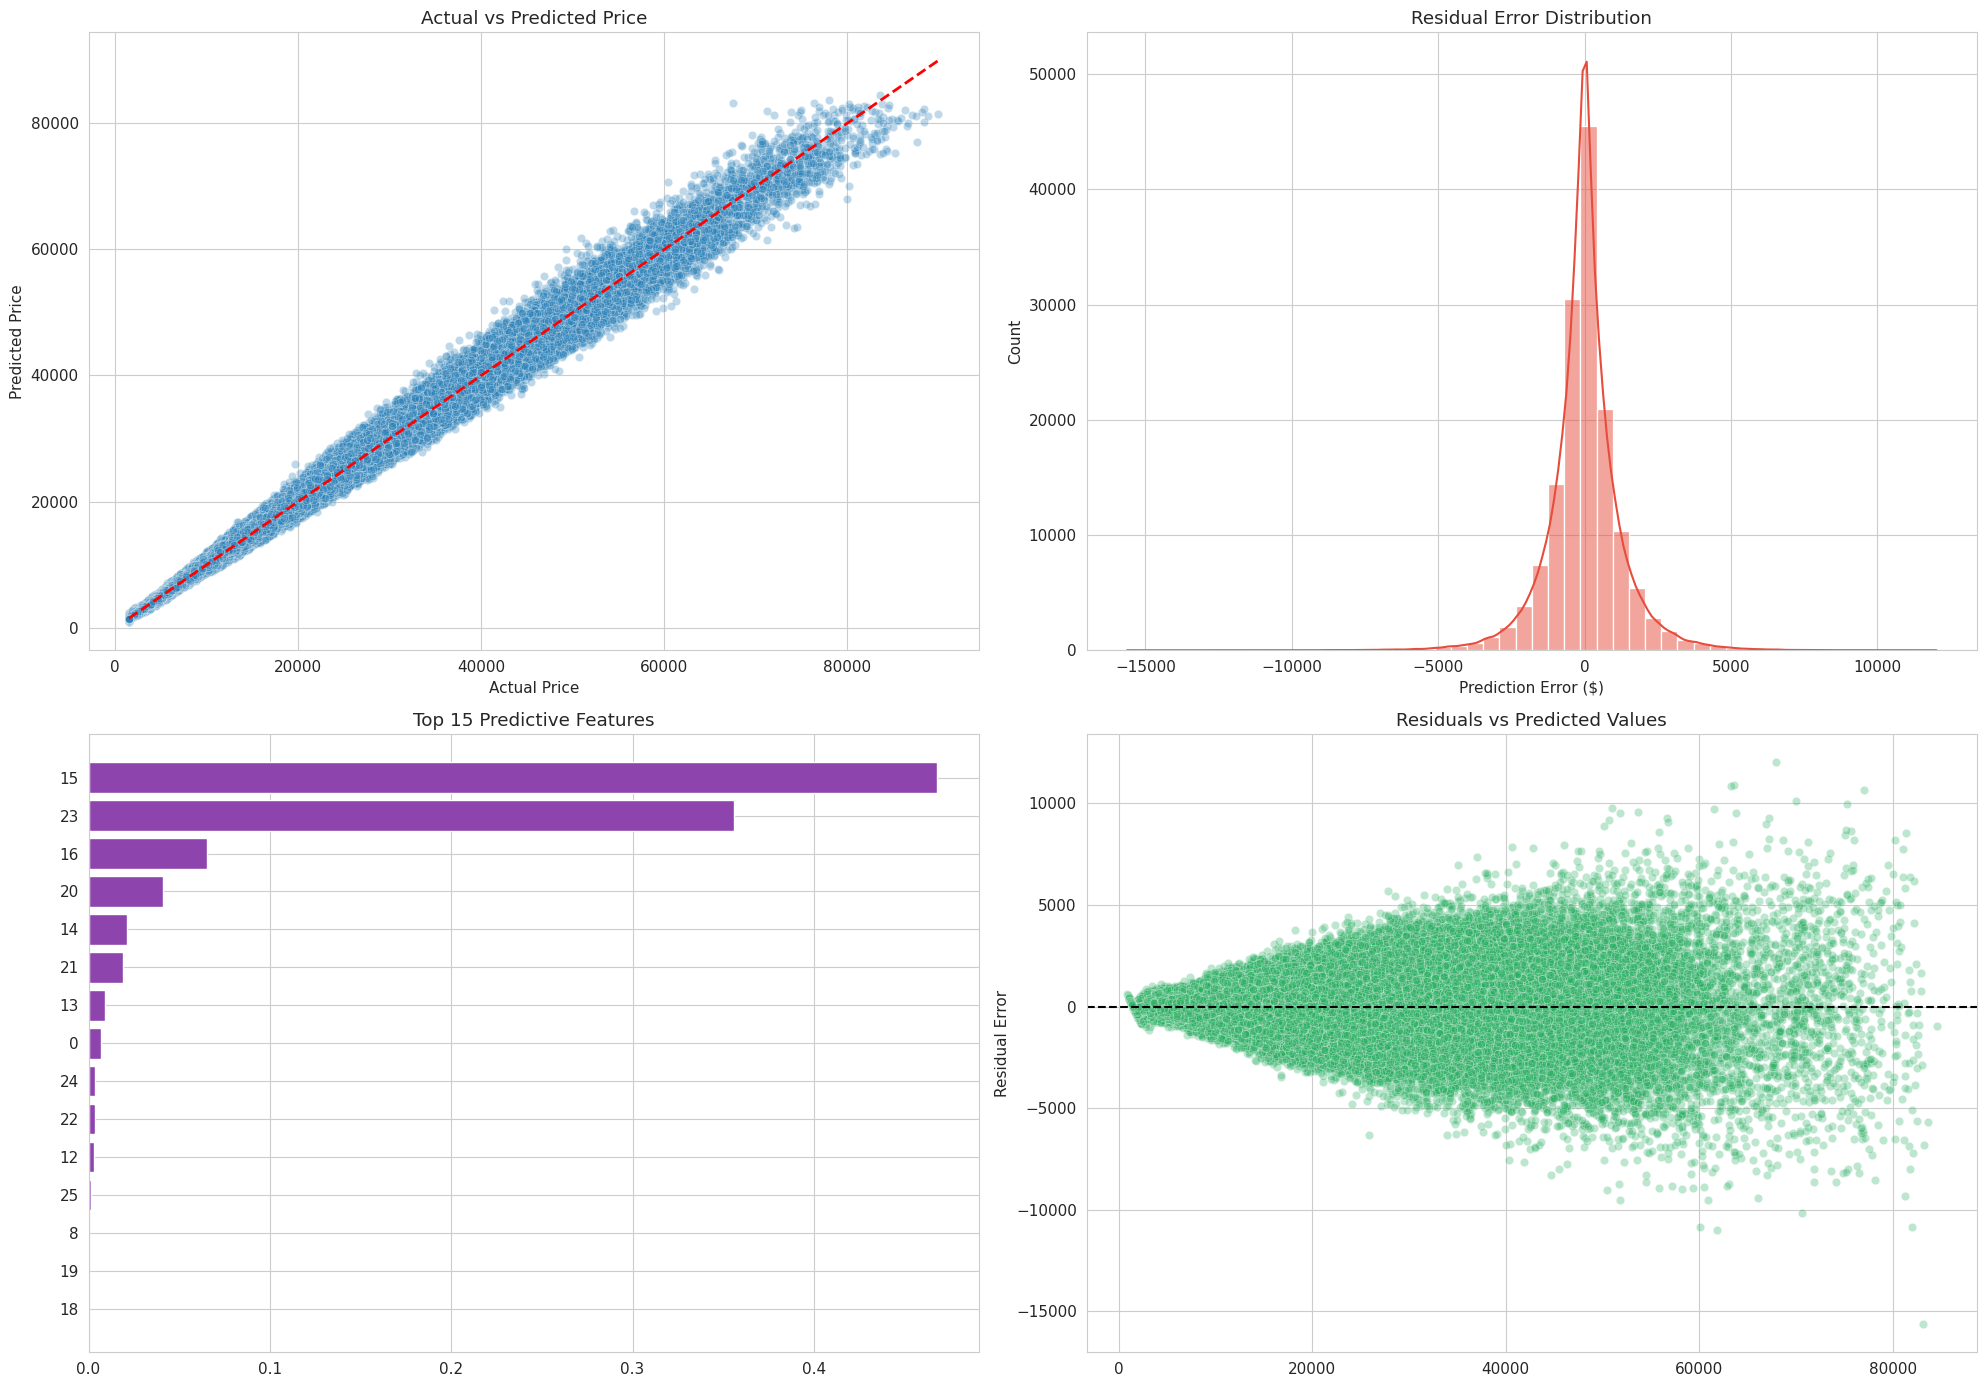

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(20, 14))

# A. Regression Fit
sns.scatterplot(x=y_test, y=y_pred, alpha=0.3, color='#2980b9', ax=axes[0, 0])
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 0].set_title('Actual vs Predicted Price')
axes[0, 0].set_xlabel('Actual Price')
axes[0, 0].set_ylabel('Predicted Price')

# B. Error Distribution
residuals = y_test - y_pred
sns.histplot(residuals, bins=50, kde=True, color='#e74c3c', ax=axes[0, 1])
axes[0, 1].set_title('Residual Error Distribution')
axes[0, 1].set_xlabel('Prediction Error ($)')

# C. Feature Importance
xgb_model = pipeline.named_steps['regressor']
importances = xgb_model.feature_importances_
indices = np.argsort(importances)[-15:] 

axes[1, 0].barh(range(len(indices)), importances[indices], color='#8e44ad')
axes[1, 0].set_title('Top 15 Predictive Features')
axes[1, 0].set_yticks(range(len(indices)))
axes[1, 0].set_yticklabels(indices) 

# D. Homoscedasticity Check
sns.scatterplot(x=y_pred, y=residuals, alpha=0.3, color='#27ae60', ax=axes[1, 1])
axes[1, 1].axhline(0, color='black', linestyle='--')
axes[1, 1].set_title('Residuals vs Predicted Values')
axes[1, 1].set_ylabel('Residual Error')

plt.tight_layout()
plt.show()

**ARTIFACT EXPORT FOR DEPLOYMENT**

In [14]:
joblib.dump(pipeline, 'vehicle_price_pipeline.pkl')
joblib.dump(list(X.columns), 'input_columns.pkl')

print("✅ Deployment Artifacts Saved:")
print("   1. vehicle_price_pipeline.pkl")
print("   2. input_columns.pkl")

✅ Deployment Artifacts Saved:
   1. vehicle_price_pipeline.pkl
   2. input_columns.pkl
